# CUWALID TRAINING

## DRYP: Creating a catchment scale model

This section (in bold) is part of the CUWALID training material:

1. ***Preparing model input parameters and dataset***
2. Running a catchment scale DRYP model
3. Post-processing DRYP model outputs


### 1. Preprocessing datasets

This section will help you to create all datasets required to develop a catchment scale model. This catchment scale model is based on the regional model parameters created for the Horn of Africa Dryland region (HAD). Therefore, model parameters are only available for the east part of the HAD. If you want to create a new model for an area outside the HAD you will have to create your own set of parameters. Global datasets can be used for initial parameterization, thus, data can be found in repositories such as Hydrosheds, SoilGrids, etc.

The following sections use CUWALID Python functions developed to handle raster datasets and preprocessing model parameters. However, you can create your parameters with your preferred software or package. CUWALID preprocessing functions perform basic tasks, therefore, complex operations can be performed using any GIS software (e.g. ArcMap, QGis) or Python libraries such as rasterio.

The following steps will be carried out in order to produce a set of gridded model parameters for a selected basin of the HAD region.

1. Delineate a new subbasin from the regional model domain
2. Create basin domain
3. Create a flow direction map compatible with the DRYP-Landlab format
4. Create a river network
5. Create a constant head boundary condition from the water table depth
6. Create basin parameters from regional datasets


In [27]:
# Import libraries from a local repository
import os
import sys
#sys.path.append("C:/Users/Edisson/Documents/GitHub/CUWALID") # DELETE THIS LINE AS THE PACKAGE CONTAINS ALL

import cuwalid.dryp.components.DRYP_watershed as ppbasin # component for basin delineation
import cuwalid.tools.DRYP_plot_tools as plotcwld # component to read model input files
import cuwalid.tools.DRYP_pptools as pptools # Component for postprocessing model output files
import cuwalid.tools.DRYP_rrtools as rrtools # Component for preprocessing raster datasets

**ATTENTION**: Before we start, please **download and unzip** all files required for this training from the following link: 
https://drive.google.com/drive/folders/11QNxnsud9l4NNtm1r5TvIf2wHl9Afgfr?usp=drive_link

The material downloaded from the link contain the different directories followin the structure below, do not change the structure as it may affect the execution of some functions of this Jupyter Notebook:

**WARNING**: Once the training files are downloaded change the paths below to access them during this training material.

In [28]:
training_general_path = "D:/HAD/training/historical/"
regional_path = "D:/HAD/training/historical/regional/model/"
basin_path = "D:/HAD/training/historical/basin/model/"

#### 1. Delineate a watershed (getting a basin mask)

The first step for creating a new model is to delineate the model domain or the extent of the study site.

We will use regional datasets to create a basin-scale model, therefore, we will use a reference model setup (*.JSON file) to create all the files required for the basin model.

In [29]:
# Path for the regional model to use as a reference model. 
path_input = os.path.join(regional_path, "HAD_input.json")

In [30]:
# read input file of reference model (you can also use any library to open JSON files)
path_parameters = plotcwld.read_json_file(path_input)

The paths of the regional model's model parameters are read and stored in a Python dictionary, so to access any of them, make sure you use the corresponding key. You can find a description of each of the keys in the Input-helper tool: https://cuwalid.github.io/tools/input-helper/

In [31]:
# Show the list of model parameters used in the regional model
path_parameters

{'model_name': 'HAD_sim',
 'path_input': '/home/c1755103/HAD/model/',
 'TERRAIN': {'path_dem': 'input/HAD_DEM_utm_mm.asc',
  'path_Qo': 'HAD_output/HAD_IMERGcu_sim83_2022_avg_Q_ini.asc',
  'path_fdl': 'input/HAD_flowdir_land_utm.asc',
  'path_riv_decay': 'input/HAD_decay_utm_v2.asc',
  'path_mask': 'input/HAD_mask_utm_m.asc',
  'path_riv_len': 'input/HAD_riv_length_utm_v2.asc',
  'path_riv_width': 'input/HAD_width_utm_v2.asc',
  'path_riv_elev': 'input/HAD_riv_elev_15pc_utm_m_sm_v3.asc'},
 'VEGETATION': {'path_veg_kc': None, 'path_veg_lulc': None},
 'UNSATURATED': {'path_uz_theta_sat': 'input/HAD_theta_sat_utm_m.asc',
  'path_uz_theta_awc': 'input/HAD_theta_awc_utm.asc',
  'path_uz_theta_wp': 'input/HAD_theta_wp_utm.asc',
  'path_uz_rootdepth': 'input/HAD_rootdepth_stocker_2023_filled_factor.asc',
  'path_uz_lambda': 'input/HAD_lambdas_utm_m.asc',
  'path_uz_psi': 'input/HAD_psi_utm_m.asc',
  'path_uz_ksat': 'input/HAD_ksat_utm_zhung.asc',
  'path_uz_theta': 'HAD_output/HAD_IMERGcu_sim


To delineate a basin you need the following information:

* A *Digital elevation model (DEM)* or a *flow direction map*
* Location of the catchment outlet

***WARNING*** To use the CUWALID delineation tool, you have to provide the Digital Elevation Map (DEM) or the flow direction as a raster (*.ASC) files, and the basin outlet as *.CSV file

First, specify path of parameter files and create maps for each one of them.

In [32]:
# regional datasets (rgn)
path_rgn_surface = os.path.join(regional_path, path_parameters["TERRAIN"]["path_dem"])
path_rgn_flowdir = os.path.join(regional_path, path_parameters["TERRAIN"]["path_fdl"])
# Basin dataset (bsn)
path_bsn_outlet = os.path.join(basin_path, "input/AW_HAD_outlet.csv")

**TASK**: Visualize the raster datasets, use the following function to quickly create a map. You can also quickly visualize those raster datasets using the CUWALID app: https://github.com/CUWALID/CUWALID-App/releases

In [33]:
import matplotlib.pyplot as plt
import rasterio
# This function can be used for plotting raster maps, modify this at your convenience.
def plot_raster_file(fname, ax=None, vmin=-20.0, vmax=20.0):
    # create plot
    if ax is None:
        fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('coolwarm_r', 12)
    data = rasterio.open(fname).read(1)
    im = ax.imshow(data,# origin="lower",#cmap=cmap, 
                   #vmin=vmin, vmax=vmax,
                   )#extent=bounds)	
    
    ax.axis('off')
    plt.colorbar(im)
    return im

C:\Users\Edisson\AppData\Local\Temp\ipykernel_34948\1850137118.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


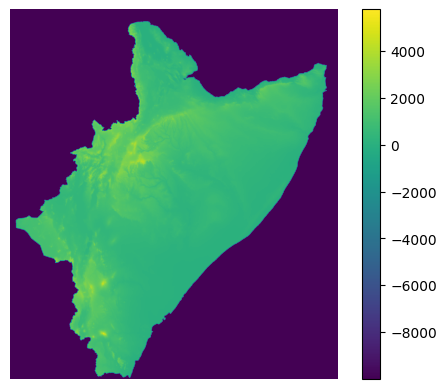

In [34]:
plot_raster_file(path_rgn_surface)

In [35]:
path_rgn_flowdirD8 = os.path.join(regional_path, "input/HAD_flowdir_D8.asc")

C:\Users\Edisson\AppData\Local\Temp\ipykernel_34948\1850137118.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


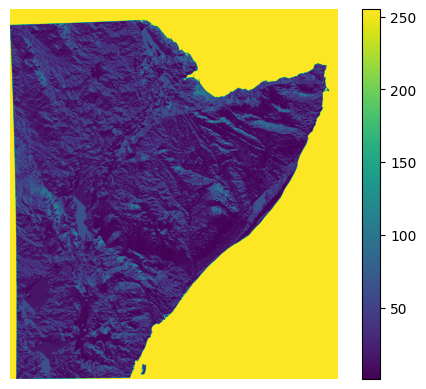

In [36]:
plot_raster_file(path_rgn_flowdirD8)

C:\Users\Edisson\AppData\Local\Temp\ipykernel_34948\1850137118.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


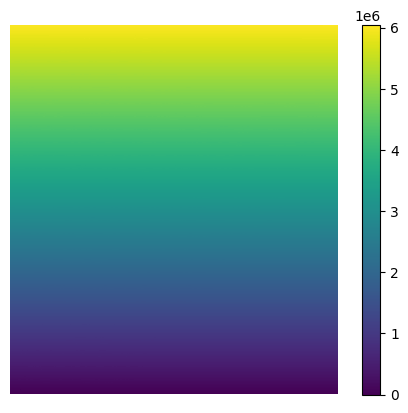

In [37]:
plot_raster_file(path_rgn_flowdir)

To delineate the basin you can provide DEM only, however, you can also provide the Landlab flow direction map. If only the DEM is provided, the flow direction map will be calculated but it will not be stored.

**We recommend providing the flow direction map as it may yield better results.**

Specify the path of the output file, if None is provided, the function will automatically generate a name by adding the the word *_basin* at the end of the surface input file


In [38]:
fname_out = None

In [39]:
# run the basin delineation function
ppbasin.get_watershed_mask(path_rgn_surface, path_bsn_outlet, fname_flowDir=path_rgn_flowdir, fname_out=fname_out)

C:\Users\Edisson\.conda\envs\tdryp\Lib\site-packages\landlab\graph\graph.py:403: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
C:\Users\Edisson\.conda\envs\tdryp\Lib\site-packages\landlab\graph\graph.py:490: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["link"]
C:\Users\Edisson\.conda\envs\tdryp\Lib\site-packages\landlab\graph\graph.py:869: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names

The output of this function is a raster file. **Remember**, If the name of the output file, *fname_out* is not provided, this file will be stored in the same directory as the surface file and it will have the same name as the surface (input file) but added "*_basin*" at the end.

In [40]:
# path of the raster file containing the basin mask within the regional domain
path_rgn_mask = os.path.join(regional_path, "input/HAD_DEM_utm_mm_basin.asc")

Plot the map containing the basin mask

C:\Users\Edisson\AppData\Local\Temp\ipykernel_34948\1850137118.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


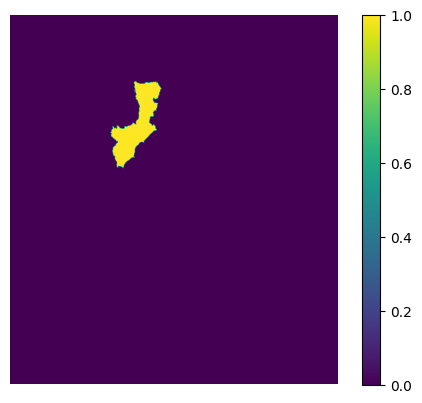

In [41]:
plot_raster_file(path_rgn_mask)

You can also calculate the area of the basin by using the following function and the basin mask, created in the previous step. The output file is a *.CSV file and the name, if not provided, will be the name of the input file added *_area* at the end the file.

In [42]:
# Run fuction to calculate the area of the basin
ppbasin.get_watershed_area(path_rgn_surface, path_bsn_outlet, fname_flowDir=path_rgn_flowdir, fname_mask=path_rgn_mask)

C:\Users\Edisson\.conda\envs\tdryp\Lib\site-packages\landlab\graph\graph.py:403: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
C:\Users\Edisson\.conda\envs\tdryp\Lib\site-packages\landlab\graph\graph.py:490: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["link"]
C:\Users\Edisson\.conda\envs\tdryp\Lib\site-packages\landlab\graph\graph.py:869: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names

**TASK** Read the csv file created in the previous state to check the catchment area

**TASK**: Visualize the created datasets

#### 2. Create a basin model domain

The new model domain can be created by clipping the regional datasets by the extent of the newly delineated basin.

The following step will clip the raster files by identifying the extent of the basin provided in the mask. The extent is specified by the area containing all positive values of the mask.

In [43]:
# path of the flow accumulation file
path_rgn_acum = os.path.join(regional_path, "input/HAD_DEM_utm_mm_flowaccum.asc")

In [44]:
# path of the new basin mask that will be the output of the clipping process
path_bsn_mask = os.path.join(basin_path, "input/AW_HAD_mask.asc")

Clip flow accumulation file

In [45]:
# reduce the size of the basin by clipping the exted of the mask from the regional raster file
rrtools.clip_raster_by_mask(path_rgn_mask, path_rgn_mask, path_bsn_mask)

**TASK**: Visualize the created datasets

#### 3. Create a flow direction map

DRYP may require a flow direction map (optional, but recommended!) to calculate the flow routing over the entire model domain. You can provide this flow direction map, however, the format used must follow a LandLab notation 
(https://landlab.readthedocs.io/en/latest/reference/components/flow_director.html).

You can create a Flow direction map using any software or may use files already available in the public domain (e.g. Hydrosheds). These files are usually in D8 format, therefore, you must transform them into a LandLab format.

The following steps will help you with this:

In [46]:
# path of the flow direction map with a D8 format, the path of the new file that will be created
path_bsn_flowdirD8 = os.path.join(basin_path, "input/AW_HAD_flowdir_D8.asc")

Clip flow direction map

In [47]:
# Clip the regional file by using the basin mask
rrtools.clip_raster_by_mask(path_rgn_flowdirD8, path_rgn_mask, path_bsn_flowdirD8)

In [48]:
# path of the new flow direction map for the basin model, the path of the new file that will be created
path_bsn_flowdir = os.path.join(basin_path, "input/AW_HAD_flowdir.asc")

Create a flow direction map by translating your D8 into a LandLab format

In [49]:
# translate the D8 file into a landlab format
rrtools.create_raster_flowdirection_dryp(path_bsn_flowdirD8, path_bsn_flowdir)

**TASK**: Visualize the created datasets

#### 4. Creating a river network

River networks can be created by filtering the flow accumulation map. Here, we use the flow accumulation map
created in the previous step to build the river network. We use a threshold to specify the minimum number of cells or the minimum area required to create a stream.

In [50]:
# Specified a threshold, this threshold could be in units of area or number of grids
threshold = 10

Clip flow accumulation map

In [51]:
# path of the basin flow accumulation map, the path of the new file that will be created
path_bsn_acum = os.path.join(basin_path, "input/AW_HAD_acum.asc")

In [52]:
# clip the regional file by using the basin mask
rrtools.clip_raster_by_mask(path_rgn_acum, path_rgn_mask, path_bsn_acum)

In [53]:
# path of the basin river network map, the path of the new file that will be created
path_bsn_river = os.path.join(basin_path, "input/AW_HAD_river.asc")

Create river network map by filtering the flow accumulation map.

In [54]:
rrtools.create_raster_river_network(path_bsn_acum, threshold, path_bsn_river, cell_area=False, fill_value=1000)

**TASK**: Change the threshold to see how the river network varies

**TASK**: Visualize the created datasets

#### 5. Create constant head boundary condition

In [55]:
#fname_wte = regional_path + "model/inputs/HAD_long_term_wte_ini.asc"
#fname_outlet = regional_path + "model/inputs/HAD_tana_dryp_station_utm.csv"
#fname_output = basin_path + "model/input/TA_HAD_CHB_utm.asc"

In [57]:
#rrtools.create_raster_bc_at_point(fname_wte, fname_outlet, fname_output)

**TASK**: Modify the list of points in the csv file create a new file for head boundary conditions.

#### 6. Create basin parameters

In [58]:
import glob

files = glob.glob(regional_path+"/input/*.asc")

In [59]:
new_path = basin_path+"input/AW_"
fnames = []
for ifile in files:
    #fnames.append(ifile.split("\\")[-1])
    new_name = new_path + ifile.split("\\")[-1]
    fnames.append(new_name)
    print(new_name)
    #new_name = new_path + fnames[0]
    #process clip raster
    rrtools.clip_raster_by_mask(ifile, path_rgn_mask, new_name)

D:/HAD/training/historical/basin/model/input/AW_HAD_ali2024_ponds_max_area_utm_no_lakes.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_ali2024_ponds_max_depth_utm_no_lakes.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_BDdepth_utm_m_sm_v2.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_CHBm_utm.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_D2E_sy_ghlymps_utm_mmm.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_decay_utm_v2.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_DEM_utm_mm.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_DEM_utm_mm_basin.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_DEM_utm_mm_flowaccum.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_flowdir_D8.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_flowdir_land_utm.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_globathymetry_utm.asc
D:/HAD/training/historical/basin/model/input/AW_HAD_IMERGcv_input_sim85_test_2000_avg_Q_ini.asc

**Check that all raster datasets are correct**

When processing raster datasets, it may happen that not all datasets have the same extent so you should first verify that all data have consistent dimensions.

The code below helps you to identify the datasets that are not consistent with the model domain.

In [60]:
#### fname_base needs to be updated
fname_base = basin_path+"input/AW_HAD_DEM_utm_mm.asc"
for ifname in fnames:
    rrtools.check_raster_alignaments(fname_base, ifname)

Reference: (361, 616, 919.241896152628) Dataset: (360, 617, 919.241896153) D:/HAD/training/historical/basin/model/input/AW_HAD_DEM_utm_mm_flowaccum.asc


In [61]:
files

['D:/HAD/training/historical/regional/model//input\\HAD_ali2024_ponds_max_area_utm_no_lakes.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_ali2024_ponds_max_depth_utm_no_lakes.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_BDdepth_utm_m_sm_v2.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_CHBm_utm.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_D2E_sy_ghlymps_utm_mmm.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_decay_utm_v2.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_DEM_utm_mm.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_DEM_utm_mm_basin.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_DEM_utm_mm_flowaccum.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_flowdir_D8.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_flowdir_land_utm.asc',
 'D:/HAD/training/historical/regional/model//input\\HAD_globathymetry_utm.asc',
 'D:/HAD/training/histo